In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_csv('data/Pregnancy-During-the-COVID-19-Pandemic.csv')

In [2]:
df.head()

,OSF_ID,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Delivery_Date(converted to month and year),Birth_Length,Birth_Weight,Delivery_Mode,NICU_Stay,Language,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm
0,1,38.3,"$200,000+",Masters degree,9.0,13.0,39.71,Dec2020,49.20,3431.0,Vaginally,No,English,2,3,27
1,2,34.6,"$200,000+",Undergraduate degree,4.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,English,2,33,92
2,3,34.3,"$100,000 -$124,999",Undergraduate degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,French,,,
3,4,28.8,"$100,000 -$124,999",Masters degree,9.0,20.0,38.57,Dec2020,41.00,2534.0,Vaginally,No,French,53,67,54
4,5,36.5,"$40,000-$69,999",Undergraduate degree,14.0,20.0,39.86,Oct2020,53.34,3714.0,Caesarean-section (c-section),No,English,23,32,71


In [3]:
df.shape # qtd de linhas e colunas

(10772, 16)

In [4]:
# dropa colunas desnecessárias
df.drop(columns = ["OSF_ID","Language"], inplace = True)
df.head()

,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Delivery_Date(converted to month and year),Birth_Length,Birth_Weight,Delivery_Mode,NICU_Stay,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm
0,38.3,"$200,000+",Masters degree,9.0,13.0,39.71,Dec2020,49.20,3431.0,Vaginally,No,2,3,27
1,34.6,"$200,000+",Undergraduate degree,4.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,2,33,92
2,34.3,"$100,000 -$124,999",Undergraduate degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,
3,28.8,"$100,000 -$124,999",Masters degree,9.0,20.0,38.57,Dec2020,41.00,2534.0,Vaginally,No,53,67,54
4,36.5,"$40,000-$69,999",Undergraduate degree,14.0,20.0,39.86,Oct2020,53.34,3714.0,Caesarean-section (c-section),No,23,32,71


In [5]:
# substituindo espaços em branco por "NaN" (nulo), para interpretação correta
df.replace(" ", np.nan, inplace=True)

In [6]:
# checar existência de linhas duplicadas
# o duplicated() considera duplicação a repetição de valores de uma linha inteira (todas as colunas)
# importante lembrar que se linhas possuem valores null nas mesmas colunas elas tbm são consideradas duplicatas
df.duplicated().sum()

np.int64(43)

In [7]:
# calcula a % de valores nulos que cada coluna possui
df.isnull().mean()*100

Maternal_Age                                   1.030449
Household_Income                               2.330115
Maternal_Education                             1.643149
Edinburgh_Postnatal_Depression_Scale          10.898626
PROMIS_Anxiety                                11.195693
Gestational_Age_At_Birth                      37.486075
Delivery_Date(converted to month and year)    37.495358
Birth_Length                                  49.127367
Birth_Weight                                  43.575938
Delivery_Mode                                 48.598218
NICU_Stay                                     48.626068
Threaten_Life                                  8.317861
Threaten_Baby_Danger                           8.392128
Threaten_Baby_Harm                             8.280728
dtype: float64

In [8]:
# mostra a qtd de colunas com valores null em cada linha
null_count = df.isnull().sum(axis=1)
print(null_count)

0         0
1         6
2        11
3         0
4         0
         ..
10767     6
10768    11
10769     6
10770     6
10771     3
Length: 10772, dtype: int64


In [9]:
# removendo linhas com +10 valores nulos 
df = df[null_count <= 10]
df.shape

(10245, 14)

In [10]:
# por serem colunas importantes, as linhas que possuem valores nulos nas colunas Edinburgh_Postnatal_Depression_Scale,
# PROMIS_Anxiety, Threaten_Life, Threaten_Baby_Danger e Threaten_Baby_Harm serão dropadas ao invés de terem seu valor substituído
# por alguma medida de tendência central (como moda, média e mediana) pois seriam valores "falsos", gerados artificialmente.
# Essa decisão foi tomada pois as colunas citadas têm porcentagens consideradas baixas para presença de valores nulos como foi
# mostrado (11.19%, 8.31%, 8.39% e 8.28% respectivamente)

df = df.dropna(subset=['Threaten_Life', 'Threaten_Baby_Danger', 'Threaten_Baby_Harm', 'PROMIS_Anxiety', 'Edinburgh_Postnatal_Depression_Scale'])

In [11]:
df.shape

(9566, 14)

In [12]:
# inexistência de valores duplicados
df.duplicated().sum()

np.int64(0)

In [13]:
# renomeando colunas
df.rename(columns={'Delivery_Date(converted to month and year)': 'Delivery_Date'}, inplace=True)
df.head()

,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Delivery_Date,Birth_Length,Birth_Weight,Delivery_Mode,NICU_Stay,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm
0,38.3,"$200,000+",Masters degree,9.0,13.0,39.71,Dec2020,49.20,3431.0,Vaginally,No,2,3,27
1,34.6,"$200,000+",Undergraduate degree,4.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,2,33,92
3,28.8,"$100,000 -$124,999",Masters degree,9.0,20.0,38.57,Dec2020,41.00,2534.0,Vaginally,No,53,67,54
4,36.5,"$40,000-$69,999",Undergraduate degree,14.0,20.0,39.86,Oct2020,53.34,3714.0,Caesarean-section (c-section),No,23,32,71
5,38.3,"$150,000 - $174,999",Undergraduate degree,3.0,8.0,38.57,Jun2020,NaN,NaN,NaN,NaN,29,36,33


In [14]:
# converter Delivery_Date pra datetime para poder calcular a média das datas
df['Delivery_Date'] = pd.to_datetime(df['Delivery_Date'], format='%b%Y')
str(df.dtypes['Delivery_Date'])
df['Delivery_Date'].head(10)

0    2020-12-01
1           NaT
3    2020-12-01
4    2020-10-01
5    2020-06-01
6           NaT
8    2020-11-01
10          NaT
13   2020-10-01
14   2021-03-01
Name: Delivery_Date, dtype: datetime64[ns]

In [15]:
# os valores nulos na Delivery_Date vão ser substituídos pela média das datas
# checando frequência de cada valor
df['Delivery_Date'].value_counts()

Delivery_Date
2020-08-01    647
2020-07-01    611
2020-09-01    602
2020-10-01    579
2020-06-01    484
2020-11-01    447
2021-01-01    375
2020-12-01    373
2021-03-01    340
2021-04-01    294
2021-02-01    279
2021-05-01    260
2021-06-01    247
2020-05-01    203
2021-07-01    186
2021-08-01    120
2021-09-01     76
2021-10-01     42
2021-11-01     17
2020-04-01     11
2022-09-01      4
2022-07-01      4
2022-06-01      4
2021-12-01      4
2022-03-01      2
2022-08-01      2
2022-01-01      1
2022-02-01      1
2022-05-01      1
Name: count, dtype: int64

In [16]:
# substituindo pela média
df["Delivery_Date"].fillna(df["Delivery_Date"].mean(), inplace=True)
df['Delivery_Date'] = df['Delivery_Date'].dt.strftime('%m/%Y')

df["Delivery_Date"].isnull().mean()*100 # 0% de valores nulos

C:\Users\Paloma\AppData\Local\Temp\ipykernel_12368\2917669021.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Delivery_Date"].fillna(df["Delivery_Date"].mean(), inplace=True)


np.float64(0.0)

In [17]:
# ver valores da Delivery_Date
df["Delivery_Date"].head()

0    12/2020
1    11/2020
3    12/2020
4    10/2020
5    06/2020
Name: Delivery_Date, dtype: object

<Axes: ylabel='Frequency'>

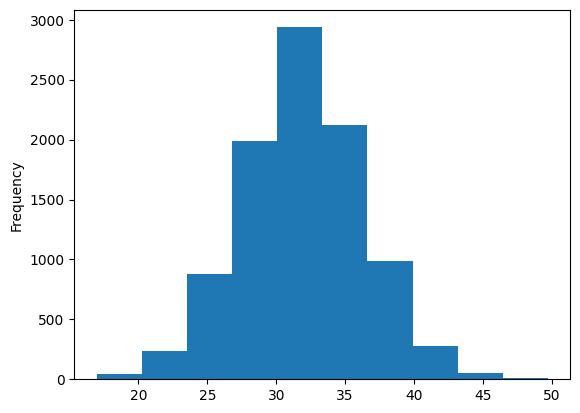

In [18]:
# checando se existem outliers em Maternal_Age
df["Maternal_Age"].plot.hist()

In [19]:
# substituindo valores nulos pela média, que foi escolhida por não haver presença de outliers significativos
# foi decidido substituir porque a porcentagem de NaNs é baixíssima e não é vantajoso excluir
# linhas onde Maternal_Age é nula
df["Maternal_Age"].fillna(df["Maternal_Age"].mean(), inplace=True)
df["Maternal_Age"].isnull().mean()*100 # 0% de valores nulos

np.float64(0.0)

In [20]:
# convertendo valores de Maternal_Age para inteiro (arredondamento)
df["Maternal_Age"] = df["Maternal_Age"].round().astype(int)
df.head()

,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Delivery_Date,Birth_Length,Birth_Weight,Delivery_Mode,NICU_Stay,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm
0,38,"$200,000+",Masters degree,9.0,13.0,39.71,12/2020,49.20,3431.0,Vaginally,No,2,3,27
1,35,"$200,000+",Undergraduate degree,4.0,17.0,NaN,11/2020,NaN,NaN,NaN,NaN,2,33,92
3,29,"$100,000 -$124,999",Masters degree,9.0,20.0,38.57,12/2020,41.00,2534.0,Vaginally,No,53,67,54
4,36,"$40,000-$69,999",Undergraduate degree,14.0,20.0,39.86,10/2020,53.34,3714.0,Caesarean-section (c-section),No,23,32,71
5,38,"$150,000 - $174,999",Undergraduate degree,3.0,8.0,38.57,06/2020,NaN,NaN,NaN,NaN,29,36,33


In [21]:
# ver quais são os valores únicos de Household_Income
df["Household_Income"].unique()

array(['$200,000+', '$100,000 -$124,999', '$40,000-$69,999',
       '$150,000 - $174,999', '$70,000-$99,999', '$175,000- $199,999',
       '$125,000- $149,999', '$20,000- $39,999', 'Less than $20, 000',
       nan], dtype=object)

In [22]:
# ver quais são os valores únicos de Maternal_Education
df["Maternal_Education"].unique()

array(['Masters degree', 'Undergraduate degree', 'High school diploma',
       'College/trade school', 'Less than high school diploma',
       'Doctoral Degree', nan], dtype=object)

In [23]:
# precisamos fazer ENCODING em algumas features para que possam ser interpretadas corretamente pelos modelos.
# serão feitos one-hot encoding nas colunas NICU_Stay e Delivery_Mode, assim não corre o risco de seus valores serem interpretados
# do jeito errado (por exemplo criando distâncias inexistentes entre certos valores, mantendo a equidistância entre eles).
# Label Encoding será feito nas colunas Household_Income e Maternal_Education

# substituindo NaNs por unknown em Household_Income
df['Household_Income'] = df['Household_Income'].fillna('Unknown')
df['Household_Income'].unique()

array(['$200,000+', '$100,000 -$124,999', '$40,000-$69,999',
       '$150,000 - $174,999', '$70,000-$99,999', '$175,000- $199,999',
       '$125,000- $149,999', '$20,000- $39,999', 'Less than $20, 000',
       'Unknown'], dtype=object)

In [24]:
# dicionário de levels
household_level = {
    'Unknown': 0,
    'Less than $20, 000': 1,
    '$20,000- $39,999': 2,
    '$40,000-$69,999': 3,
    '$70,000-$99,999': 4,
    '$100,000 -$124,999': 5,
    '$125,000- $149,999': 6,
    '$150,000 - $174,999': 7,
    '$175,000- $199,999': 8,
    '$200,000+': 9,
}

# substituindo valores pelos levels
df['Household_Income'] = df['Household_Income'].replace(household_level).infer_objects(copy=False).astype(int)
df['Household_Income'].head(10)

C:\Users\Paloma\AppData\Local\Temp\ipykernel_12368\429889731.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Household_Income'] = df['Household_Income'].replace(household_level).infer_objects(copy=False).astype(int)


0     9
1     9
3     5
4     3
5     7
6     9
8     5
10    4
13    4
14    9
Name: Household_Income, dtype: int64

In [25]:
# substituindo NaNs por unknown em Maternal_Education
df["Maternal_Education"] = df["Maternal_Education"].fillna("Unknown")
df["Maternal_Education"].unique()

array(['Masters degree', 'Undergraduate degree', 'High school diploma',
       'College/trade school', 'Less than high school diploma',
       'Doctoral Degree', 'Unknown'], dtype=object)

In [26]:
# dicionário de levels
education_level = {
    'Unknown': 0,
    'Less than high school diploma': 1,
    'High school diploma': 2,
    'College/trade school': 3,
    'Undergraduate degree': 4,
    'Masters degree': 5,
    'Doctoral Degree': 6,
}

# substituindo valores pelos levels
df["Maternal_Education"] = df["Maternal_Education"].replace(education_level).infer_objects(copy=False).astype(int)
df["Maternal_Education"].head(10)

C:\Users\Paloma\AppData\Local\Temp\ipykernel_12368\2029550412.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Maternal_Education"] = df["Maternal_Education"].replace(education_level).infer_objects(copy=False).astype(int)


0     5
1     4
3     5
4     4
5     4
6     2
8     3
10    1
13    5
14    6
Name: Maternal_Education, dtype: int64

In [27]:
# visualizar dados
df.head(10)

,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Delivery_Date,Birth_Length,Birth_Weight,Delivery_Mode,NICU_Stay,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm
0,38,9,5,9.0,13.0,39.71,12/2020,49.20,3431.0,Vaginally,No,2,3,27
1,35,9,4,4.0,17.0,NaN,11/2020,NaN,NaN,NaN,NaN,2,33,92
3,29,5,5,9.0,20.0,38.57,12/2020,41.00,2534.0,Vaginally,No,53,67,54
4,36,3,4,14.0,20.0,39.86,10/2020,53.34,3714.0,Caesarean-section (c-section),No,23,32,71
5,38,7,4,3.0,8.0,38.57,06/2020,NaN,NaN,NaN,NaN,29,36,33
6,34,9,2,8.0,15.0,NaN,11/2020,NaN,NaN,NaN,NaN,24,30,32
8,33,5,3,1.0,7.0,40.86,11/2020,55.88,4480.0,Vaginally,No,27,76,72
10,29,4,1,20.0,28.0,NaN,11/2020,NaN,NaN,NaN,NaN,0,50,98
13,29,4,5,14.0,17.0,41.00,10/2020,47.00,3084.0,Vaginally,No,68,69,81
14,32,9,6,3.0,14.0,30.29,03/2021,32.00,1050.0,Caesarean-section (c-section),Yes,30,30,50


In [28]:
# one-hot encoding

# NICU_Stay
# substituindo valores NaN por unknown
df["NICU_Stay"] = df["NICU_Stay"].fillna("Unknown")
df["NICU_Stay"].unique()

array(['No', 'Unknown', 'Yes'], dtype=object)

In [29]:
# criando as colunas do encoding
df = pd.get_dummies(df, columns=["NICU_Stay"], dtype=int)
df.head()

,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Delivery_Date,Birth_Length,Birth_Weight,Delivery_Mode,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm,NICU_Stay_No,NICU_Stay_Unknown,NICU_Stay_Yes
0,38,9,5,9.0,13.0,39.71,12/2020,49.20,3431.0,Vaginally,2,3,27,1,0,0
1,35,9,4,4.0,17.0,NaN,11/2020,NaN,NaN,NaN,2,33,92,0,1,0
3,29,5,5,9.0,20.0,38.57,12/2020,41.00,2534.0,Vaginally,53,67,54,1,0,0
4,36,3,4,14.0,20.0,39.86,10/2020,53.34,3714.0,Caesarean-section (c-section),23,32,71,1,0,0
5,38,7,4,3.0,8.0,38.57,06/2020,NaN,NaN,NaN,29,36,33,0,1,0


In [30]:
# Delivery_Mode
# substituindo valores NaN por unknown
df["Delivery_Mode"] = df["Delivery_Mode"].fillna("Unknown")
df["Delivery_Mode"].unique()

array(['Vaginally', 'Unknown', 'Caesarean-section (c-section)'],
      dtype=object)

In [31]:
# criando as colunas do encoding
df = pd.get_dummies(df, columns=["Delivery_Mode"], dtype=int)
df.head()

,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Delivery_Date,Birth_Length,Birth_Weight,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm,NICU_Stay_No,NICU_Stay_Unknown,NICU_Stay_Yes,Delivery_Mode_Caesarean-section (c-section),Delivery_Mode_Unknown,Delivery_Mode_Vaginally
0,38,9,5,9.0,13.0,39.71,12/2020,49.20,3431.0,2,3,27,1,0,0,0,0,1
1,35,9,4,4.0,17.0,NaN,11/2020,NaN,NaN,2,33,92,0,1,0,0,1,0
3,29,5,5,9.0,20.0,38.57,12/2020,41.00,2534.0,53,67,54,1,0,0,0,0,1
4,36,3,4,14.0,20.0,39.86,10/2020,53.34,3714.0,23,32,71,1,0,0,1,0,0
5,38,7,4,3.0,8.0,38.57,06/2020,NaN,NaN,29,36,33,0,1,0,0,1,0


<Axes: ylabel='Frequency'>

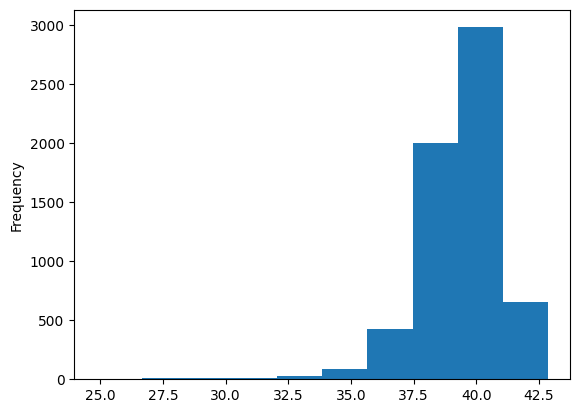

In [32]:
# encontrando outliers em outras colunas para encontrar melhor medida de tendência central para substituição
# de nulos: média, moda ou mediana
df["Gestational_Age_At_Birth"].plot.hist()

<Axes: ylabel='Frequency'>

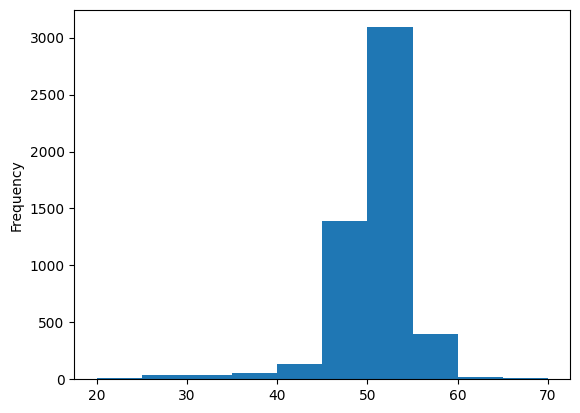

In [33]:
df["Birth_Length"].plot.hist()

<Axes: ylabel='Frequency'>

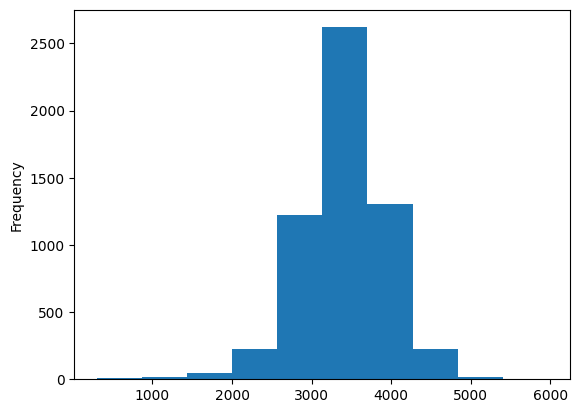

In [34]:
df["Birth_Weight"].plot.hist()

In [35]:
# substituindo nulos em Gestational_Age_At_Birth pela sua média
df["Gestational_Age_At_Birth"].fillna(df["Gestational_Age_At_Birth"].mean(), inplace=True)
df["Gestational_Age_At_Birth"].isnull().mean()*100 # 0% de valores nulos

np.float64(0.0)

In [36]:
# substituindo nulos em Birth_Length pela sua média
df["Birth_Length"].fillna(df["Birth_Length"].mean(), inplace=True)
df["Birth_Length"].isnull().mean()*100 # 0% de valores nulos

np.float64(0.0)

In [37]:
# substituindo nulos em Birth_Length pela sua média
df["Birth_Weight"].fillna(df["Birth_Weight"].mean(), inplace=True)
# convertendo de gramas pra quilos
df["Birth_Weight"] = df["Birth_Weight"]/1000

df["Birth_Weight"].isnull().mean()*100 # 0% de valores nulos

np.float64(0.0)

In [38]:
# renomeando coluna para Delivery_Mode_Caesarean
df.rename(columns={'Delivery_Mode_Caesarean-section (c-section)': 'Delivery_Mode_Caesarean'}, inplace=True)
df.head(10)

,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Delivery_Date,Birth_Length,Birth_Weight,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm,NICU_Stay_No,NICU_Stay_Unknown,NICU_Stay_Yes,Delivery_Mode_Caesarean,Delivery_Mode_Unknown,Delivery_Mode_Vaginally
0,38,9,5,9.0,13.0,39.710000,12/2020,49.200000,3.431000,2,3,27,1,0,0,0,0,1
1,35,9,4,4.0,17.0,39.351094,11/2020,50.499156,3.410886,2,33,92,0,1,0,0,1,0
3,29,5,5,9.0,20.0,38.570000,12/2020,41.000000,2.534000,53,67,54,1,0,0,0,0,1
4,36,3,4,14.0,20.0,39.860000,10/2020,53.340000,3.714000,23,32,71,1,0,0,1,0,0
5,38,7,4,3.0,8.0,38.570000,06/2020,50.499156,3.410886,29,36,33,0,1,0,0,1,0
6,34,9,2,8.0,15.0,39.351094,11/2020,50.499156,3.410886,24,30,32,0,1,0,0,1,0
8,33,5,3,1.0,7.0,40.860000,11/2020,55.880000,4.480000,27,76,72,1,0,0,0,0,1
10,29,4,1,20.0,28.0,39.351094,11/2020,50.499156,3.410886,0,50,98,0,1,0,0,1,0
13,29,4,5,14.0,17.0,41.000000,10/2020,47.000000,3.084000,68,69,81,1,0,0,0,0,1
14,32,9,6,3.0,14.0,30.290000,03/2021,32.000000,1.050000,30,30,50,0,0,1,1,0,0


In [39]:
# Agora o dataset não possui mais nenhum valor nulo. Pré-processamento feito.

Text(0.5, 1.0, 'Distribuição da Idade')

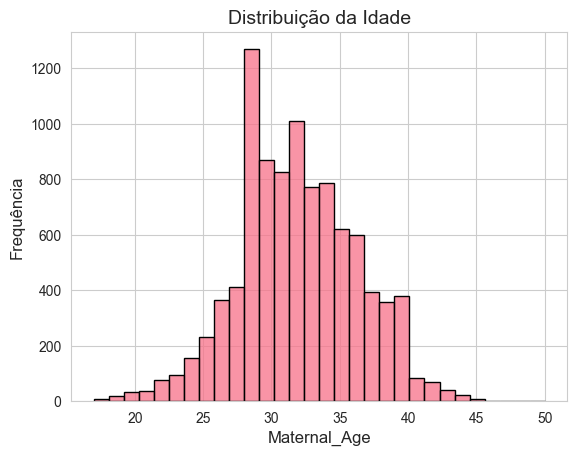

In [40]:
# Plotar algumas estatísticas das principais colunas

# Maternal_Age
sns.set_style("whitegrid")
sns.histplot(df['Maternal_Age'], bins=30, color=sns.color_palette("husl", 10)[0], edgecolor="black")

# Adicionar rótulos e título
plt.xlabel('Maternal_Age', fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.title(f"Distribuição da Idade", fontsize=14)

Text(0.5, 1.0, 'Distribuição da Escolaridade')

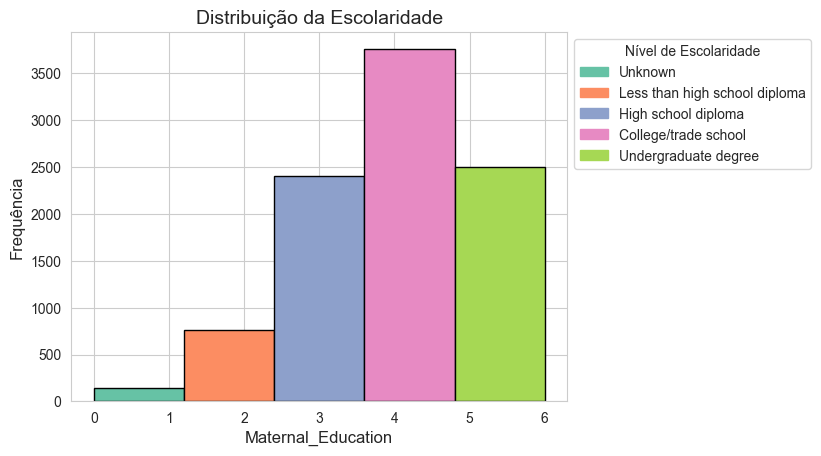

In [41]:
# Maternal_Education
sns.set_style("whitegrid")
ax = sns.histplot(df['Maternal_Education'], bins=5, edgecolor="black")
colors = sns.color_palette("Set2", len(ax.patches))

for patch, color in zip(ax.patches, colors):
    patch.set_facecolor(color)

handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]

plt.legend(handles, education_level, title="Nível de Escolaridade", loc="upper left", bbox_to_anchor=(1, 1))

# Adicionar rótulos e título
plt.xlabel('Maternal_Education', fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.title(f"Distribuição da Escolaridade", fontsize=14)

Text(0.5, 1.0, 'Distribuição da Renda Familiar')

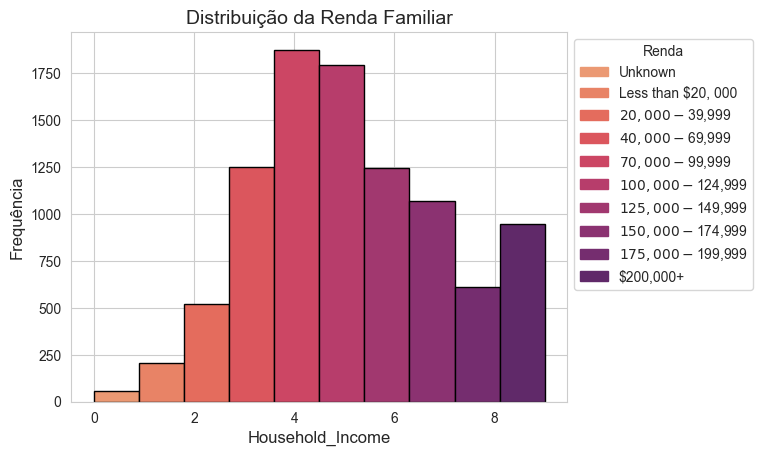

In [42]:
# Household_Income
sns.set_style("whitegrid")
ax = sns.histplot(df['Household_Income'], bins=10, edgecolor="black")
colors = sns.color_palette("flare", len(ax.patches))

for patch, color in zip(ax.patches, colors):
    patch.set_facecolor(color)

handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]

plt.legend(handles, household_level, title="Renda", loc="upper left", bbox_to_anchor=(1, 1))

# Adicionar rótulos e título
plt.xlabel('Household_Income', fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.title(f"Distribuição da Renda Familiar", fontsize=14)

In [49]:
df = df.round({'Gestational_Age_At_Birth': 2, 'Birth_Length': 2, 'Birth_Weight': 2})
df.head()

,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Delivery_Date,Birth_Length,Birth_Weight,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm,NICU_Stay_No,NICU_Stay_Unknown,NICU_Stay_Yes,Delivery_Mode_Caesarean,Delivery_Mode_Unknown,Delivery_Mode_Vaginally
5502,32,0,0,0.0,7.0,38.14,01/2021,53.34,3.54,13,16,50,1,0,0,0,0,1
293,36,8,4,10.0,20.0,38.43,09/2020,50.50,2.41,36,27,24,0,1,0,0,1,0
8086,32,5,4,2.0,10.0,41.29,08/2021,52.00,4.08,50,19,91,1,0,0,0,0,1
1164,29,5,4,9.0,25.0,40.29,01/2021,52.83,3.67,27,34,65,1,0,0,0,0,1
10607,32,7,4,6.0,12.0,37.43,09/2020,51.00,2.98,49,75,100,1,0,0,1,0,0


In [47]:
# Implementação do 10-fold cross-validation
# cria o CV com 10 folds para cada repetição, serão 5 repetições e a cada repetição
# o dataset será embaralhado, usando este CV o modelo vai ser executado 50 vezes
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

# embaralhando data frame
df = sklearn.utils.shuffle(df)

# divisão de features e target
df_features = df.drop(columns=['PROMIS_Anxiety'])
df_target = df['PROMIS_Anxiety']

# instanciação de modelo
knn = KNeighborsClassifier(n_neighbors=2)

# avaliação do modelo (a melhorar: mudar tipo de scoring)
# treina e avalia o modelo 50 vezes conforme o CV, dessa forma existirão 50 scores
# a média dos scores será usada como score final para avaliação do modelo
scores = cross_val_score(knn, df_features, df_target, scoring='accuracy', cv=cv, n_jobs=-1)

# verificar performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Paloma\Documents\UFRPE\Inteligência Artificial\Projeto-IA-2VA\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Paloma\Documents\UFRPE\Inteligência Artificial\Projeto-IA-2VA\venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Paloma\Documents\UFRPE\Inteligência Artificial\Projeto-IA-2VA\venv\Lib\site-packages\sklearn\neighbors\_classification.py", line 239, in fit
    return self._fit(X, y)
           ^^^^^^^^^^^^^^^
  File "C:\Users\Paloma\Documents\UFRPE\Inteligência Artificial\Projeto-IA-2VA\venv\Lib\site-packages\sklearn\neighbors\_base.py", line 478, in _fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "C:\Users\Paloma\Documents\UFRPE\Inteligência Artificial\Projeto-IA-2VA\venv\Lib\site-packages\sklearn\utils\validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Paloma\Documents\UFRPE\Inteligência Artificial\Projeto-IA-2VA\venv\Lib\site-packages\sklearn\utils\validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\Paloma\Documents\UFRPE\Inteligência Artificial\Projeto-IA-2VA\venv\Lib\site-packages\sklearn\utils\validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Paloma\Documents\UFRPE\Inteligência Artificial\Projeto-IA-2VA\venv\Lib\site-packages\sklearn\utils\_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Paloma\Documents\UFRPE\Inteligência Artificial\Projeto-IA-2VA\venv\Lib\site-packages\pandas\core\generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: '01/2021'

--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Paloma\Documents\UFRPE\Inteligência Artificial\Projeto-IA-2VA\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Paloma\Documents\UFRPE\Inteligência Artificial\Projeto-IA-2VA\venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Paloma\Documents\UFRPE\Inteligência Artificial\Projeto-IA-2VA\venv\Lib\site-packages\sklearn\neighbors\_classification.py", line 239, in fit
    return self._fit(X, y)
           ^^^^^^^^^^^^^^^
  File "C:\Users\Paloma\Documents\UFRPE\Inteligência Artificial\Projeto-IA-2VA\venv\Lib\site-packages\sklearn\neighbors\_base.py", line 478, in _fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "C:\Users\Paloma\Documents\UFRPE\Inteligência Artificial\Projeto-IA-2VA\venv\Lib\site-packages\sklearn\utils\validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Paloma\Documents\UFRPE\Inteligência Artificial\Projeto-IA-2VA\venv\Lib\site-packages\sklearn\utils\validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\Paloma\Documents\UFRPE\Inteligência Artificial\Projeto-IA-2VA\venv\Lib\site-packages\sklearn\utils\validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Paloma\Documents\UFRPE\Inteligência Artificial\Projeto-IA-2VA\venv\Lib\site-packages\sklearn\utils\_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Paloma\Documents\UFRPE\Inteligência Artificial\Projeto-IA-2VA\venv\Lib\site-packages\pandas\core\generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: '09/2020'
